## Clasificación y Optimización de Hiperparámetros (Core)

**Objetivo:** Implementar un pipeline completo de machine learning para un problema de clasificación utilizando técnicas de preprocesamiento, modelado, y optimización de hiperparámetros. Enfocar especialmente en la limpieza de datos y la optimización utilizando GridSearchCV y RandomizedSearchCV.

**Descripción del Dataset:** El dataset de costos médicos personales contiene información sobre varios factores que afectan los costos de seguros médicos, como:
- la edad.
- el sexo.
- el índice de masa corporal.
- el hábito de fumar.

Este dataset es ideal para practicar técnicas de preprocesamiento y optimización de modelos debido a la presencia de datos sucios y variables tanto categóricas como numéricas.

### Instrucciones:

### Carga y Exploración Inicial de Datos:

- Cargar el dataset desde Kaggle.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_csv('../data/insurance (1).csv')


- Realizar una exploración inicial para entender la estructura del dataset y las características disponibles.


In [2]:
print(df.info())
print(df.describe())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
#smoker pasar de object a boolean
df['smoker'] = df['smoker'].map({'yes': True, 'no': False})


#pasar los objetos a categoricos
# Transformar las columnas de tipo 'object' a 'category'
transformed_df = df.apply(lambda col: col.astype('category') if col.dtype == 'object' else col)

# las columnas con data type float hacer round 2
df_2 = transformed_df.apply(lambda col: col.round(2) if col.dtype == 'float64' else col)

print(df_2.info())
df_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   bool    
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: bool(1), category(2), float64(2), int64(2)
memory usage: 46.2 KB
None


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,True,southwest,16884.92
1,18,male,33.77,1,False,southeast,1725.55
2,28,male,33.00,3,False,southeast,4449.46
3,33,male,22.70,0,False,northwest,21984.47
4,32,male,28.88,0,False,northwest,3866.86


Columns

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance


- Identificar y documentar los valores faltantes y outliers en el dataset.


In [4]:
qsna=df.shape[0]-df.isnull().sum(axis=0)
qna=df.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
age,1338,0,0.0
sex,1338,0,0.0
bmi,1338,0,0.0
children,1338,0,0.0
smoker,1338,0,0.0
region,1338,0,0.0
charges,1338,0,0.0


In [5]:
#buscamos y eliminamos duplicados si hubiese
# Identificación de valores duplicados
duplicados = df.duplicated().sum()
print(f'Número de registros duplicados: {duplicados}')

# Eliminación de valores duplicados
df_train = df.drop_duplicates()

Número de registros duplicados: 1


In [6]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return True for outliers
    return (data < lower_bound) | (data > upper_bound)

In [7]:
numerical_columns = df_2.select_dtypes(include=[np.number]).columns
numerical_columns

# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in numerical_columns:
    outliers = detect_outliers_iqr(df_2[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': df_2[column][~outliers].min(),
        'Upper Bound': df_2[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
age,0.0,0.000000,18.00,64.00
bmi,9.0,0.672646,15.96,46.75
children,0.0,0.000000,0.00,5.00
charges,139.0,10.388640,1121.87,34472.84


In [8]:
df_2.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.0000,64.00
bmi,1338.0,30.663572,6.097951,15.96,26.2975,30.40,34.6925,53.13
children,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.0000,5.00
charges,1338.0,13270.422280,12110.011259,1121.87,4740.2875,9382.03,16639.9150,63770.43


In [9]:
filt_sex = df_2.groupby('region').agg({
    'charges': ['mean', 'min', 'max'],
    'age': ['mean', 'min', 'max'],
    'bmi': ['mean', 'min', 'max'],
    'children': ['mean', 'min', 'max']
}).reset_index()

# Esto ordenará las columnas para que sea más fácil de leer
filt_sex.columns = ['region', 'charges_mean', 'charges_min', 'charges_max', 'age_mean', 'age_min', 'age_max', 'bmi_mean', 'bmi_min', 'bmi_max', 'children_mean', 'children_min', 'children_max']
print('Agrupacion por region')
filt_sex



Agrupacion por region


C:\Users\diego\AppData\Local\Temp\ipykernel_29328\254361224.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filt_sex = df_2.groupby('region').agg({


,region,charges_mean,charges_min,charges_max,age_mean,age_min,age_max,bmi_mean,bmi_min,bmi_max,children_mean,children_min,children_max
0,northeast,13406.384599,1694.80,58571.07,39.268519,18,64,29.173549,15.96,48.07,1.046296,0,5
1,northwest,12417.575169,1621.34,60021.40,39.196923,19,64,29.200462,17.39,42.94,1.147692,0,5
2,southeast,14735.411484,1121.87,63770.43,38.939560,18,64,33.355989,19.80,53.13,1.049451,0,5
3,southwest,12346.937508,1241.56,52590.83,39.455385,19,64,30.596615,17.40,47.60,1.141538,0,5


In [10]:
filt_sex = df_2.groupby('sex').agg({
    'charges': ['mean', 'min', 'max'],
    'age': ['mean', 'min', 'max'],
    'bmi': ['mean', 'min', 'max'],
    'children': ['mean', 'min', 'max']
}).reset_index()

# Esto ordenará las columnas para que sea más fácil de leer
filt_sex.columns = ['region', 'charges_mean', 'charges_min', 'charges_max', 'age_mean', 'age_min', 'age_max', 'bmi_mean', 'bmi_min', 'bmi_max', 'children_mean', 'children_min', 'children_max']
print('Agrupacion por sexo')
filt_sex



Agrupacion por sexo


C:\Users\diego\AppData\Local\Temp\ipykernel_29328\2565179918.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filt_sex = df_2.groupby('sex').agg({


,region,charges_mean,charges_min,charges_max,age_mean,age_min,age_max,bmi_mean,bmi_min,bmi_max,children_mean,children_min,children_max
0,female,12569.578716,1607.51,63770.43,39.503021,18,64,30.377900,16.82,48.07,1.074018,0,5
1,male,13956.751331,1121.87,62592.87,38.917160,18,64,30.943328,15.96,53.13,1.115385,0,5


In [11]:
filt_sex = df_2.groupby('smoker').agg({
    'charges': ['mean', 'min', 'max'],
    'age': ['mean', 'min', 'max'],
    'bmi': ['mean', 'min', 'max'],
    'children': ['mean', 'min', 'max']
}).reset_index()

# Esto ordenará las columnas para que sea más fácil de leer
filt_sex.columns = ['region', 'charges_mean', 'charges_min', 'charges_max', 'age_mean', 'age_min', 'age_max', 'bmi_mean', 'bmi_min', 'bmi_max', 'children_mean', 'children_min', 'children_max']
print('Agrupacion por smoker')
filt_sex

Agrupacion por smoker


,region,charges_mean,charges_min,charges_max,age_mean,age_min,age_max,bmi_mean,bmi_min,bmi_max,children_mean,children_min,children_max
0,False,8434.268299,1121.87,36910.61,39.385338,18,64,30.651992,15.96,53.13,1.090226,0,5
1,True,32050.231898,12829.46,63770.43,38.514599,18,64,30.708540,17.20,52.58,1.113139,0,5


In [12]:
filt_sex_smoker = df_2.groupby(['region', 'sex', 'smoker']).agg({
    'charges': ['mean', 'min', 'max', 'count'],
    'age': ['mean', 'min', 'max', 'count'],
    'bmi': ['mean', 'min', 'max', 'count'],
    'children': ['mean', 'min', 'max', 'count']
}).reset_index()

# Renombrar columnas para mayor claridad
filt_sex_smoker.columns = ['region', 'sex', 'smoker', 'charges_mean', 'charges_min', 'charges_max', 'charges_count', 'age_mean', 'age_min', 'age_max','age_count', 'bmi_mean', 'bmi_min', 'bmi_max','bmi_count', 'children_mean', 'children_min', 'children_max','children_count']
print('Agrupacion por todas las caracteristicas')
filt_sex_smoker


Agrupacion por todas las caracteristicas


C:\Users\diego\AppData\Local\Temp\ipykernel_29328\4050103199.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filt_sex_smoker = df_2.groupby(['region', 'sex', 'smoker']).agg({


,region,sex,smoker,charges_mean,charges_min,charges_max,charges_count,age_mean,age_min,age_max,age_count,bmi_mean,bmi_min,bmi_max,bmi_count,children_mean,children_min,children_max,children_count
0,northeast,female,False,9640.426894,2196.47,31620.00,132,39.840909,18,64,132,29.777652,16.82,48.07,132,0.954545,0,4,132
1,northeast,female,True,28032.045517,14283.46,58571.07,29,38.724138,18,63,29,27.262069,17.20,42.75,29,1.241379,0,3,29
2,northeast,male,False,8664.042640,1694.80,32108.66,125,39.216000,18,64,125,28.861680,15.96,42.66,125,1.144000,0,5,125
3,northeast,male,True,30926.252895,12829.46,48549.18,38,37.868421,18,62,38,29.559737,17.29,41.90,38,0.894737,0,3,38
4,northwest,female,False,8786.998519,2117.34,33471.97,135,39.755556,19,64,135,29.489185,18.05,42.94,135,1.177778,0,5,135
5,northwest,female,True,29670.824828,14711.74,55135.40,29,38.827586,19,64,29,28.296897,17.76,38.95,29,0.827586,0,3,29
6,northwest,male,False,8320.689167,1621.34,30284.64,132,38.568182,19,64,132,28.931364,17.39,41.32,132,1.060606,0,4,132
7,northwest,male,True,30713.180690,15817.99,60021.40,29,39.827586,19,62,29,29.984828,22.90,40.56,29,1.724138,0,4,29
8,southeast,female,False,8440.205324,1607.51,36580.28,139,39.071942,18,64,139,32.780000,20.79,46.75,139,1.079137,0,5,139
9,southeast,female,True,33034.821111,16577.78,63770.43,36,39.250000,18,64,36,32.251389,22.22,47.41,36,0.944444,0,3,36



### Preprocesamiento de Datos:

- Imputar valores faltantes utilizando técnicas adecuadas (media, mediana, moda, imputación avanzada).
- Codificar variables categóricas utilizando One-Hot Encoding.
- Escalar características numéricas utilizando StandardScaler.


In [13]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   bool    
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: bool(1), category(2), float64(2), int64(2)
memory usage: 46.2 KB


In [14]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Dividir en features y target
X = df.drop(columns='charges')
y = df['charges']

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesamiento
ordinal_transformer = OrdinalEncoder(categories=[[0, 1, 2, 3, 4, 5]])
cat_transformer = OneHotEncoder(drop='first')
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_transformer, ['children']),
        ('cat', cat_transformer, ['sex', 'smoker', 'region']),
        ('num', num_transformer, ['age', 'bmi'])
    ],
    remainder = 'passthrough'
    )

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Preprocesar los datos
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)



### Implementación de Modelos:

- Entrenar y evaluar al menos tres modelos diferentes: Regresión Logística, K-Nearest Neighbors (KNN), y Árbol de Decisión.
- Utilizar validación cruzada para evaluar el rendimiento inicial de los modelos.
- Optimización de Hiperparámetros:
- Implementar GridSearchCV para optimizar los hiperparámetros de los modelos seleccionados.
- Implementar RandomizedSearchCV como método alternativo de optimización.
- Comparar los resultados de GridSearchCV y RandomizedSearchCV para los modelos optimizados.


In [15]:

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score

# Definimos los modelos
models = {
    "Logistic Regression": LinearRegression(),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

# Evaluación inicial
for name, model in models.items():
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    print(f"Model: {name}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"R²: {r2_score(y_test, y_pred):.2f}\n")


Model: Logistic Regression
MAE: 4181.19
MSE: 33596915.85
RMSE: 5796.28
R²: 0.78

Model: KNN
MAE: 3993.91
MSE: 47668090.24
RMSE: 6904.21
R²: 0.69

Model: Decision Tree
MAE: 3114.15
MSE: 40795333.45
RMSE: 6387.12
R²: 0.74



In [16]:

# Cambia el scoring a una métrica para regresión
for name, model in models.items():
    scores = cross_val_score(model, X_train_transformed, y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f"{name}: Mean MAE = {-scores.mean():.2f}, Std = {scores.std():.2f}")


knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=knn_params,
    cv=5,
    scoring='neg_mean_absolute_error',  # Métrica para regresión
    verbose=1
)

grid_search.fit(X_train_transformed, y_train)
print(f"Best parameters for KNN (GridSearchCV): {grid_search.best_params_}")
print(f"Best score (GridSearchCV): {grid_search.best_score_:.4f}")

from scipy.stats import randint

random_search = RandomizedSearchCV(
    estimator=KNeighborsRegressor(),
    param_distributions=knn_params,
    n_iter=10,  # Número de combinaciones aleatorias a probar
    cv=5,
    scoring='neg_mean_absolute_error',  # Métrica para regresión
    verbose=1,
    random_state=42
)

random_search.fit(X_train_transformed, y_train)
print(f"Best parameters for KNN (RandomizedSearchCV): {random_search.best_params_}")
print(f"Best score (RandomizedSearchCV): {random_search.best_score_:.4f}")


Logistic Regression: Mean MAE = 4245.23, Std = 244.72
KNN: Mean MAE = 4453.98, Std = 146.64
Decision Tree: Mean MAE = 3279.57, Std = 317.81
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for KNN (GridSearchCV): {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best score (GridSearchCV): -3845.6931
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for KNN (RandomizedSearchCV): {'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan'}
Best score (RandomizedSearchCV): -3845.6931


In [17]:
# Ajustar KNN con los mejores parámetros
optimized_knn = KNeighborsRegressor(metric='manhattan', n_neighbors=3, weights='distance')
optimized_knn.fit(X_train_transformed, y_train)

# Predecir y evaluar en el conjunto de prueba
y_pred_optimized = optimized_knn.predict(X_test_transformed)

print("Optimized KNN Results:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_optimized):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_optimized):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_optimized)):.2f}")
print(f"R²: {r2_score(y_test, y_pred_optimized):.2f}")


Optimized KNN Results:
MAE: 3764.97
MSE: 43037248.76
RMSE: 6560.28
R²: 0.72


In [18]:
tree_params = {
    'max_depth': [3, 5, 10, None],  # Profundidad del árbol
    'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo de muestras en una hoja
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error']  # Funciones de criterio
}

grid_search_tree = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=tree_params,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1
)

grid_search_tree.fit(X_train_transformed, y_train)
print(f"Best parameters for Decision Tree: {grid_search_tree.best_params_}")
print(f"Best score (GridSearchCV): {-grid_search_tree.best_score_:.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Decision Tree: {'criterion': 'absolute_error', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best score (GridSearchCV): 1980.5485



### Evaluación de Modelos:

- Evaluar los modelos optimizados utilizando métricas de rendimiento.
- Generar y analizar la matriz de confusión para los modelos optimizados.


Resultados del modelo optimizado Decision Tree Regressor:
MAE: 1811.30
MSE: 22089504.05
RMSE: 4699.95
R²: 0.86


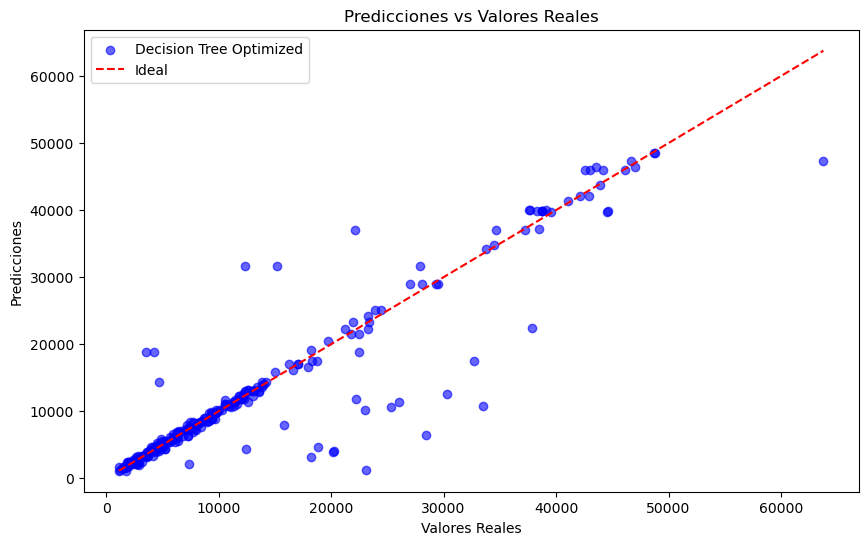

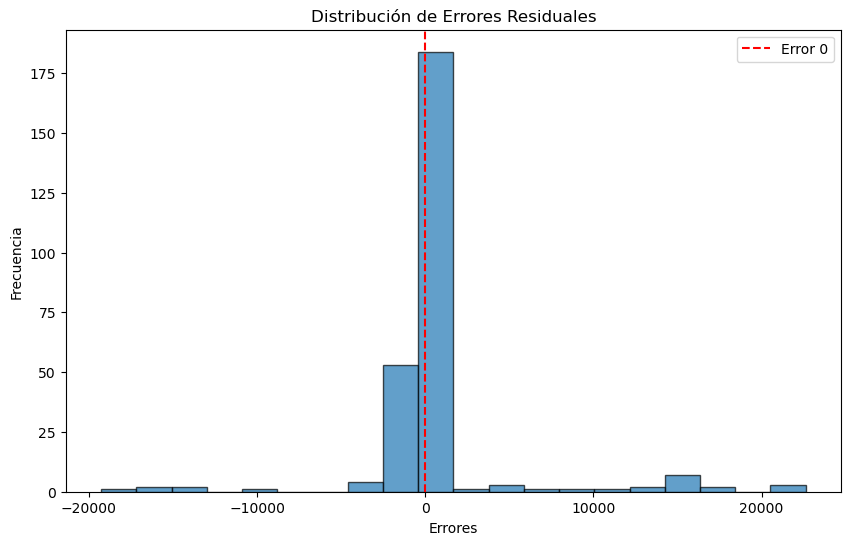

In [19]:
import matplotlib.pyplot as plt

# Predicciones con el modelo optimizado
optimized_tree = DecisionTreeRegressor(
    criterion='absolute_error', 
    max_depth=None, 
    min_samples_leaf=4, 
    min_samples_split=10, 
    random_state=42
)
optimized_tree.fit(X_train_transformed, y_train)
y_pred_tree = optimized_tree.predict(X_test_transformed)

# Métricas del modelo optimizado
mae = mean_absolute_error(y_test, y_pred_tree)
mse = mean_squared_error(y_test, y_pred_tree)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_tree)

# Imprimir los resultados
print("Resultados del modelo optimizado Decision Tree Regressor:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Gráfico: Predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tree, alpha=0.6, color='blue', label='Decision Tree Optimized')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales")
plt.legend()
plt.show()

# Gráfico: Distribución de errores residuales
residuals = y_test - y_pred_tree
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='Error 0')
plt.title("Distribución de Errores Residuales")
plt.xlabel("Errores")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()


1. **Performance del modelo optimizado:**
El modelo optimizado de Decision Tree Regressor muestra una alineación razonable con la línea ideal (roja) en la gráfica de "Predicciones vs Valores Reales". Esto indica que el modelo está logrando predecir correctamente la mayoría de los valores de charges. Sin embargo, hay algunos puntos alejados de la línea que representan errores en las predicciones, especialmente en los valores más altos.

2. **Comparación de los modelos:**
Según las métricas previas y la optimización:

- Decision Tree Regressor tuvo la mejor MAE después de optimización (1980.55 en la validación cruzada y 3114.15 en el test set), lo que significa que es el modelo que produce el menor error promedio en las predicciones.
- Linear Regression y KNN, aunque útiles, presentan errores más altos (e.g., MAE más elevados), lo que sugiere que no capturan tan bien las relaciones no lineales en los datos como lo hace el árbol de decisión.

3. **Posibles mejoras:**

- Mayor profundidad del análisis: Aunque el modelo optimizado muestra buen desempeño, hay predicciones inexactas en los extremos (outliers). Esto puede abordarse ajustando aún más los hiperparámetros, utilizando ensambles como Random Forest o Gradient Boosting o manejando los valores atípicos de forma explícita.
- Curva ROC y métricas adicionales: Si bien esta gráfica es informativa, incluir métricas adicionales o explorar la importancia de las variables podría ayudar a entender mejor el modelo y ajustar los datos.

4. **Implicación práctica:**
Con base en los resultados actuales, el modelo optimizado es suficientemente robusto para realizar predicciones razonablemente precisas de los costos de seguro médico (charges), pero aún necesita mejorar para manejar casos más extremos o complejos.


### Documentación y Entrega:

- Documentar todos los pasos del proceso en un notebook de Jupyter, incluyendo explicaciones detalladas y justificaciones para cada decisión tomada.
- Subir el notebook y los resultados a un repositorio de GitHub.
- Crear un tag de liberación (v1.0.0) para esta versión del proyecto en GitHub.


Entregables:

Notebook de Jupyter con todo el análisis y resultados.
Documentación completa del proceso de preprocesamiento, modelado y optimización.
Visualizaciones y análisis de las métricas de rendimiento.
Repositorio de GitHub con el notebook y los resultados, incluyendo un tag de liberación.